In [2]:
import os
import sys
sys.path.append('/scratch_tmp/users/k21066795/BreastAgeNet')

import glob
import random
import h5py
import staintools
import openslide
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kruskal
from skimage.measure import regionprops_table
import stardist
from stardist.models import StarDist2D
from stardist.plot import render_label
from csbdeep.utils import normalize


def parse_wsi_id(patch_id):    
    if " HE" in patch_id: # NKI
        wsi_id = patch_id.split(" HE")[0]
    elif "_FPE_" in patch_id: # KHP
        wsi_id = "_".join(patch_id.split("_")[:3])
    else: # rest
        wsi_id = patch_id.split("_")[0]
    
    return wsi_id


def get_xy(patch_id):
    try:
        x, y, patch_size = patch_id.split("_")[-3:]
        x, y, patch_size = int(x), int(y), int(patch_size)
        return x * patch_size, y * patch_size, patch_size
    except ValueError as e:
        raise ValueError(f"Invalid patch_id format: {patch_id}. Expected format '..._x_y_patch_size'.") from e


def Reinhard(img_arr):
    standard_img = "/scratch_tmp/users/k21066795/NBT-Classifier/data/he.jpg"
    target = staintools.read_image(standard_img)
    target = staintools.LuminosityStandardizer.standardize(target)
    normalizer = staintools.ReinhardColorNormalizer()
    normalizer.fit(target)
    #img = staintools.read_image(img_path)
    img_to_transform = staintools.LuminosityStandardizer.standardize(img_arr)
    img_transformed = normalizer.transform(img_to_transform)
    return img_transformed


def crop_im(img, new_width=448,new_height=448):
    width, height = img.size   # Get dimensions
    left = (width - new_width)/2
    top = (height - new_height)/2
    right = (width + new_width)/2
    bottom = (height + new_height)/2
    # Crop the center of the image
    img = img.crop((left, top, right, bottom))
    return img

In [47]:
WSIs = '/scratch_tmp/prj/cb_normalbreast/prj_BreastAgeNet/WSIs'                                             # the folder saving WSIs
PATCH = "/scratch_tmp/prj/cb_normalbreast/prj_BreastAgeNet/patches/HE"                                      # the folder to save
NUCLEI = "/scratch_tmp/prj/cb_normalbreast/prj_BreastAgeNet/patches/startdist"                              # the folder to save images of nuclei segmentation

# load cluster predictions of the train_NR dataset
df = pd.read_csv("/scratch_tmp/prj/cb_normalbreast/prj_BreastAgeNet/RESULTs/interpretation/test_NR_clean_4clusters.csv", low_memory=False)
df

,patch_id,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,...,Brca2,Cancer,Ever Had Cancer,age_group,cohort,h5df,tsne1,tsne2,Cluster,Pattern
0,K107432_57435_5589_9032_9032_238_28_259,0.870536,0.995774,0.000000,0.943857,0.438073,0.000000,1.789201,0.137976,1.252397,...,No,NaN,No,0,SGK,/scratch/prj/cb_normalbreast/Siyuan/prj_normal...,-5.937443,-93.419220,1,P1
1,K107432_13107_6367_10847_11624_73_49_259,1.595808,1.300595,0.305661,0.053197,0.000000,0.000000,2.009969,0.000000,0.230268,...,No,NaN,No,0,SGK,/scratch/prj/cb_normalbreast/Siyuan/prj_normal...,-26.220695,-87.603970,1,P1
2,K107432_13107_6367_10847_11624_51_26_259,0.000000,0.248464,0.605945,2.204580,1.224285,0.000000,0.004018,0.582045,1.145261,...,No,NaN,No,0,SGK,/scratch/prj/cb_normalbreast/Siyuan/prj_normal...,-1.714275,-137.600220,2,P2
3,K107432_13107_6367_10847_11624_70_46_259,0.000000,0.038651,0.000000,0.769126,0.000000,0.000000,0.676276,0.000000,0.171108,...,No,NaN,No,0,SGK,/scratch/prj/cb_normalbreast/Siyuan/prj_normal...,28.592417,30.630793,3,P3
4,K107432_57435_5589_9032_9032_236_33_259,1.164483,0.645204,0.000000,0.000000,0.109820,0.000000,1.172826,0.000000,0.000000,...,No,NaN,No,0,SGK,/scratch/prj/cb_normalbreast/Siyuan/prj_normal...,45.304340,25.795590,3,P3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186483,K109288_9552_6754_3011_2503_44_31_254,0.000000,0.823119,0.156524,0.479735,0.364566,0.000000,0.524836,0.173468,1.100779,...,No,NaN,No,3,SGK,/scratch/prj/cb_normalbreast/Siyuan/prj_normal...,50.903862,134.568830,3,P3
186484,K109288_9552_6754_3011_2503_42_31_254,0.681944,1.146444,1.250765,0.501220,0.000000,0.122351,0.000000,0.000000,0.804415,...,No,NaN,No,3,SGK,/scratch/prj/cb_normalbreast/Siyuan/prj_normal...,124.168460,52.535767,1,P1
186485,K109288_9552_6754_3011_2503_41_31_254,0.000000,0.786571,0.487520,0.180075,0.090788,0.000000,0.000000,0.000000,0.000000,...,No,NaN,No,3,SGK,/scratch/prj/cb_normalbreast/Siyuan/prj_normal...,127.252480,60.619728,2,P2
186486,K109288_9552_6754_3011_2503_44_29_254,0.078392,1.058542,0.966333,1.371026,0.576021,0.000000,0.000000,0.090088,1.068822,...,No,NaN,No,3,SGK,/scratch/prj/cb_normalbreast/Siyuan/prj_normal...,121.625755,55.441590,2,P2


In [ ]:
# randomly sample patches from each cluster
patch_num = 10000
for cluster_id in [0,1,2,3]:
    patch_ids = list(df.loc[df['Cluster'] == cluster_id, "patch_id"])
    print(len(patch_ids))
    random.shuffle(patch_ids)
    
    for patch_id in patch_ids[:patch_num]:
        save_pt = f"{PATCH}/{patch_id}.tif"
        print(save_pt)
        wsi_id = parse_wsi_id(patch_id)
        try:
            wsi_path = glob.glob(f"{WSIs}/*/{wsi_id}*.*")[0]
            wsi = openslide.OpenSlide(wsi_path)
            x, y, patch_size = get_xy(patch_id)
            im = wsi.read_region((x, y), 0, (patch_size, patch_size)).convert("RGB")
        except Exception as e:
            print(f"Error processing WSI {wsi_id} for patch {patch_id}: {e}")
            continue  

        # save the normalised patch
        patch_im_norm = Reinhard(np.array(im))
        patch_im_norm = Image.fromarray(patch_im_norm)
        patch_im_norm = crop_im(patch_im_norm)
        patch_im_norm.save(save_pt)

In [ ]:
# nuclei segmentation and quantification
nuclei_csv = "/scratch_tmp/prj/cb_normalbreast/prj_BreastAgeNet/RESULTs/interpretation/SGK_Cluster_nuclei_morphology.csv"   # the folder to save nuclei morphology quantification results

for patch_id in os.listdir(PATCH): 
    tar_pt = f'{NUCLEI}/{patch_id.replace(".tif", "_nu.tif")}'
    if not os.path.exists(tar_pt):
        try:
            print(tar_pt)
            patch_norm = Image.open(f"{PATCH}/{patch_id}")
            patch_im_norm = np.array(patch_norm)
            
            # apply StarDist to detect nuclei and save the mask
            model = StarDist2D.from_pretrained('2D_versatile_he')
            labels, details = model.predict_instances(normalize(patch_im_norm))
            seg_im = Image.fromarray(labels.astype(bool))
            seg_im.save(tar_pt)
            print(f"{tar_pt} saved!")
            # plot_contours(patch_im, details["coord"])
            
            # compute nuclei features
            nuclei_props_list = ["label", "area", "bbox_area", "extent", "eccentricity", "perimeter", "major_axis_length", "minor_axis_length", "solidity"]
            props = regionprops_table(labels, properties=nuclei_props_list)
            props_df = pd.DataFrame.from_dict(props)
            props_df["Circularity"] = (4*np.pi*props_df["area"]) / (props_df["major_axis_length"]**2)
            props_df["Elongation"] = props_df["major_axis_length"] / props_df["minor_axis_length"]
            props_df["patch_id"] = patch_id
            props_df["coord_x"] = details["points"][:,0]
            props_df["coord_y"] = details["points"][:,1]
            
            if not os.path.exists(nuclei_csv):
                props_df.to_csv(nuclei_csv, index=False)
            else:
                props_df.to_csv(nuclei_csv, mode="a", header=False, index=False)
        except:
            pass

In [48]:
# nuclei table
nuclei_df = pd.read_csv(nuclei_csv)
nuclei_df['patch_id'] = [i.split('.tif')[0] for i in list(nuclei_df['patch_id'])]
nuclei_df = pd.merge(nuclei_df, df.loc[:, ['patch_id', 'Cluster', 'Pattern']], on = 'patch_id')
nuclei_df.to_csv(nuclei_csv, index=False)
nuclei_df

,label,area,bbox_area,extent,eccentricity,perimeter,major_axis_length,minor_axis_length,solidity,Circularity,Elongation,patch_id,coord_x,coord_y,Cluster,Pattern
0,1,193.0,256.0,0.753906,0.451388,49.455844,16.594833,14.808031,0.955446,8.806866,1.120664,K108959_48774_4217_5561_4543_196_29_254,260,310,2,P2
1,2,146.0,182.0,0.802198,0.505477,42.384776,14.692902,12.677623,0.966887,8.498603,1.158964,K108959_48774_4217_5561_4543_196_29_254,108,334,2,P2
2,3,103.0,130.0,0.792308,0.734347,36.142136,13.913546,9.444152,0.953704,6.686078,1.473245,K108959_48774_4217_5561_4543_196_29_254,292,266,2,P2
3,4,116.0,154.0,0.753247,0.703764,38.970563,14.417547,10.242713,0.928000,7.012697,1.407591,K108959_48774_4217_5561_4543_196_29_254,150,190,2,P2
4,5,145.0,195.0,0.743590,0.730952,43.798990,16.517790,11.272219,0.947712,6.678424,1.465354,K108959_48774_4217_5561_4543_196_29_254,206,212,2,P2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1931743,11,93.0,130.0,0.715385,0.726092,34.384776,13.182262,9.064088,0.948980,6.725320,1.454340,K107731_49364_11543_2549_2290_196_47_259,304,332,2,P2
1931744,11,93.0,130.0,0.715385,0.726092,34.384776,13.182262,9.064088,0.948980,6.725320,1.454340,K107731_49364_11543_2549_2290_196_47_259,304,332,2,P2
1931745,11,93.0,130.0,0.715385,0.726092,34.384776,13.182262,9.064088,0.948980,6.725320,1.454340,K107731_49364_11543_2549_2290_196_47_259,304,332,2,P2
1931746,11,93.0,130.0,0.715385,0.726092,34.384776,13.182262,9.064088,0.948980,6.725320,1.454340,K107731_49364_11543_2549_2290_196_47_259,304,332,2,P2


In [49]:
# aggregate the nuclei table --> patch table
agg_df = nuclei_df.groupby('patch_id').agg(
    area_mean=('area', 'mean'),
    bbox_area_mean=('bbox_area', 'mean'),
    extent_mean=('extent', 'mean'),
    eccentricity_mean=('eccentricity', 'mean'),
    perimeter_mean=('perimeter', 'mean'),
    major_axis_length_mean=('major_axis_length', 'mean'),
    minor_axis_length_mean=('minor_axis_length', 'mean'),
    solidity_mean=('solidity', 'mean'),
    circularity_mean=('Circularity', 'mean'),
    elongation_mean=('Elongation', 'mean'),
    nuclei_count=('patch_id', 'size'),  
    cluster=('Cluster', lambda x: x.mode()[0]),
    Pattern=('Pattern', lambda x: x.mode()[0])  
).reset_index()


nuclei_agg = "/scratch_tmp/prj/cb_normalbreast/prj_BreastAgeNet/RESULTs/interpretation/SGK_Cluster_nuclei_morphology_patchAggregation.csv"   # the folder to save nuclei morphology quantification results
agg_df.to_csv("nuclei_agg", index=False)
agg_df

,patch_id,area_mean,bbox_area_mean,extent_mean,eccentricity_mean,perimeter_mean,major_axis_length_mean,minor_axis_length_mean,solidity_mean,circularity_mean,elongation_mean,nuclei_count,cluster,Pattern
0,K105969_2972_9656_3044_2787_15_43_256,1926.000000,2708.800000,0.706233,0.772057,149.502352,52.190686,32.107092,0.915998,5.510506,1.865560,55,3,P3
1,K105969_2972_9656_3044_2787_15_44_256,1915.400000,2578.000000,0.738072,0.639098,139.942554,47.754058,32.401593,0.934293,7.139259,1.402992,45,1,P1
2,K105969_2972_9656_3044_2787_16_42_256,999.818182,1459.363636,0.697358,0.751534,96.364571,34.486588,21.056789,0.933886,6.116491,1.677656,88,3,P3
3,K105969_2972_9656_3044_2787_16_43_256,1994.142857,2844.000000,0.721325,0.600732,151.473114,49.192441,34.640658,0.914795,7.461392,1.318308,49,1,P1
4,K105969_2972_9656_3044_2787_16_45_256,1628.833333,2256.833333,0.746006,0.507165,124.475818,41.614155,28.572540,0.929036,7.954212,1.264657,42,0,P0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39084,K109288_9552_6754_3011_2503_44_29_254,1062.454545,1398.818182,0.768378,0.523591,89.005733,31.567709,21.641334,0.954265,8.086367,1.257145,264,2,P2
39085,K109288_9552_6754_3011_2503_44_31_254,2316.500000,3163.750000,0.759583,0.551285,164.021338,54.868278,37.591101,0.928554,7.606715,1.321943,100,3,P3
39086,K109288_9552_6754_3011_2503_45_30_254,1437.300000,2032.000000,0.745986,0.638655,121.337172,39.640610,28.867345,0.929167,7.234843,1.348770,220,3,P3
39087,K109288_9552_6754_3011_2503_45_31_254,1083.700000,1428.800000,0.754230,0.621899,90.839401,32.030381,21.774133,0.945980,7.417070,1.360242,230,2,P2


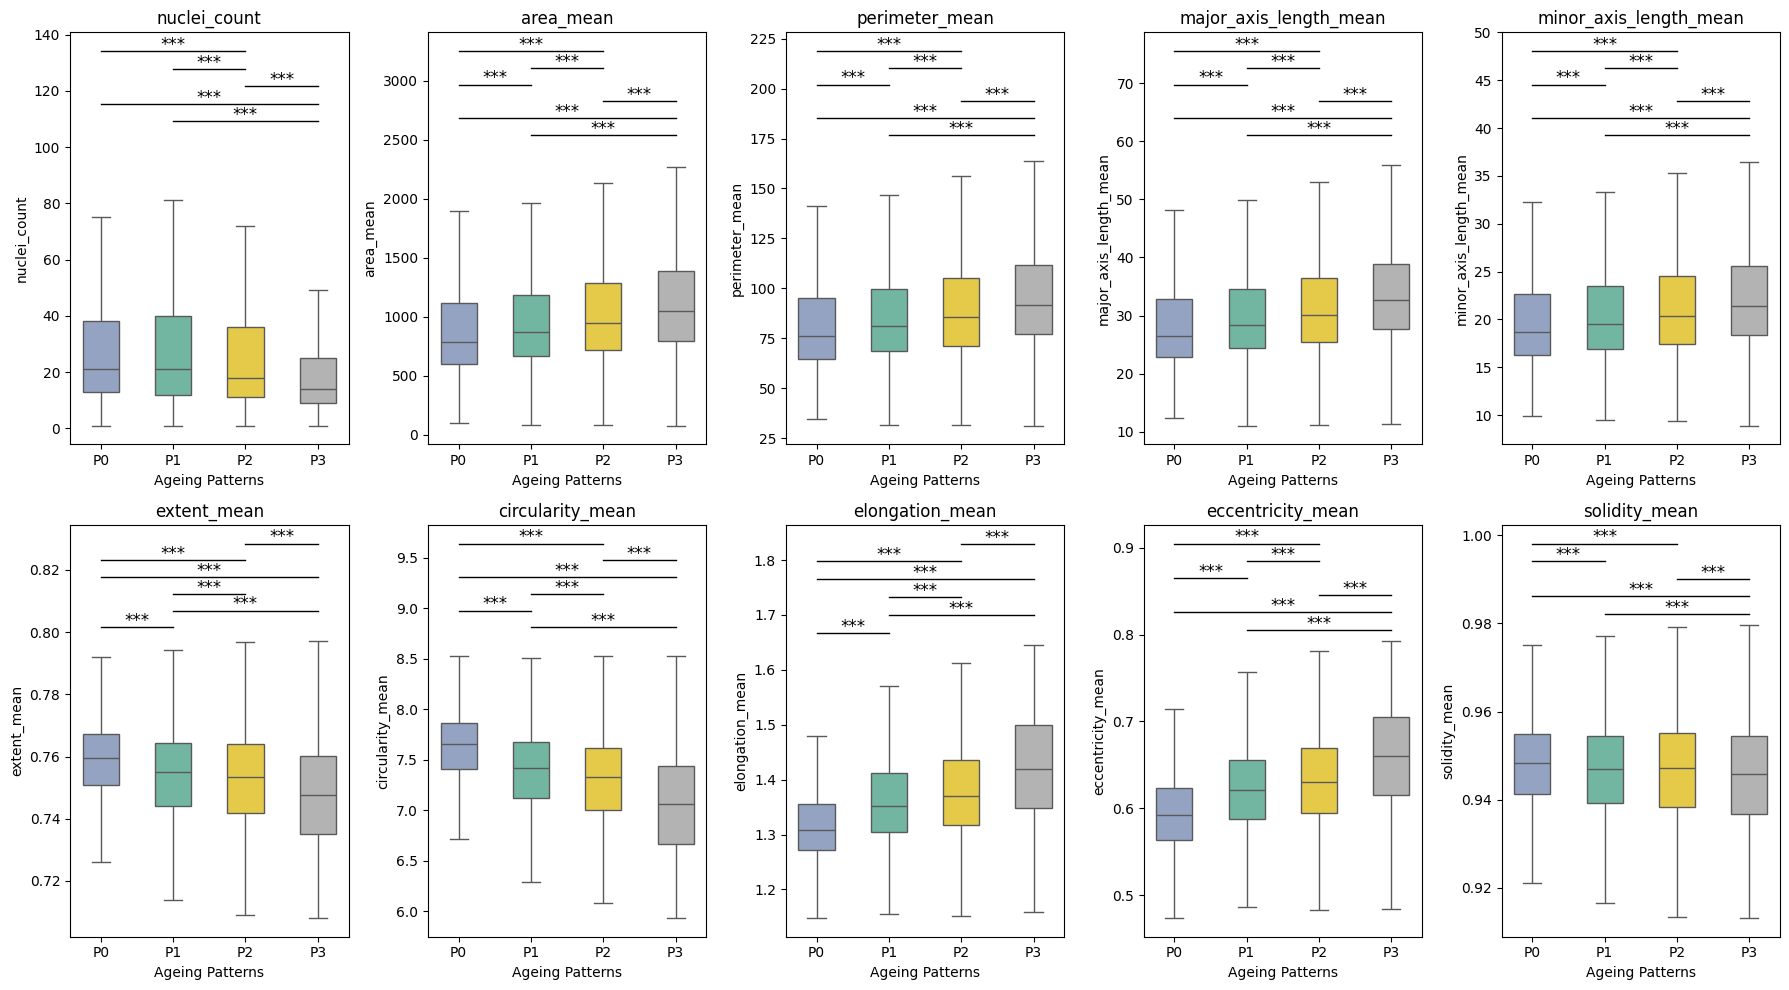

                   Feature Cluster 1 Cluster 2        p-value Significance
0             nuclei_count        P3        P1  2.617339e-182          ***
1             nuclei_count        P3        P0  9.364767e-208          ***
2             nuclei_count        P3        P2   3.912937e-69          ***
3             nuclei_count        P1        P0   3.672435e-01             
4             nuclei_count        P1        P2   2.219087e-29          ***
5             nuclei_count        P0        P2   1.057276e-35          ***
6                area_mean        P3        P1  8.491264e-140          ***
7                area_mean        P3        P0  9.394022e-283          ***
8                area_mean        P3        P2   1.869240e-44          ***
9                area_mean        P1        P0   2.666392e-37          ***
10               area_mean        P1        P2   1.593459e-29          ***
11               area_mean        P0        P2  8.218007e-118          ***
12          perimeter_mea

In [50]:
# Define cluster order and colors
cluster_orders = ['P0', 'P1', 'P2', 'P3']
cluster_colors = {'P0': '#8da0cb', 'P1': '#66c2a5', 'P2': '#ffd92f', 'P3': '#b3b3b3'}

# Features to compare
features = ['nuclei_count', 'area_mean', "perimeter_mean", "major_axis_length_mean", 
            "minor_axis_length_mean", "extent_mean", 'circularity_mean', 'elongation_mean', 
            "eccentricity_mean", "solidity_mean"]

# Initialize a DataFrame to store the p-values for each feature and cluster pair
p_value_table = []

# Set up the 2x5 grid for subplots
fig, axes = plt.subplots(2, 5, figsize=(18, 10))
axes = axes.flatten()  # Flatten the array for easy iteration

# Loop through each feature and create boxplots
for i, feature in enumerate(features):
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = agg_df[feature].quantile(0.25)
    Q3 = agg_df[feature].quantile(0.75)
    IQR = Q3 - Q1

    # Define the acceptable range (1.5 * IQR beyond the quartiles)
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter the DataFrame to remove outliers
    agg_df_filtered = agg_df[(agg_df[feature] >= lower_bound) & (agg_df[feature] <= upper_bound)]

    # Perform Kruskal-Wallis H test for each pair of clusters
    p_values = {}
    clusters = agg_df_filtered['Pattern'].unique()

    for j, cluster1 in enumerate(clusters):
        for cluster2 in clusters[j + 1:]:
            data1 = agg_df_filtered[agg_df_filtered['Pattern'] == cluster1][feature]
            data2 = agg_df_filtered[agg_df_filtered['Pattern'] == cluster2][feature]
            _, p_val = kruskal(data1, data2)

            # Assign significance markers
            if p_val < 0.001:
                significance = '***'
            elif p_val < 0.01:
                significance = '**'
            elif p_val < 0.05:
                significance = '*'
            else:
                significance = ''

            p_values[(cluster1, cluster2)] = (p_val, significance)

            # Add p-values to the table
            p_value_table.append({
                'Feature': feature,
                'Cluster 1': cluster1,
                'Cluster 2': cluster2,
                'p-value': p_val,
                'Significance': significance
            })

    # Create boxplot in subplot
    sns.boxplot(ax=axes[i], x='Pattern', y=feature, data=agg_df_filtered, 
                hue='Pattern', palette=cluster_colors, order=cluster_orders, 
                showfliers=False, width=0.5, legend=False)
    
    axes[i].set_title(f'{feature}')
    axes[i].set_xlabel('Ageing Patterns')
    axes[i].set_ylabel(feature)

    # Add significance annotations above the boxplots for each subplot
    y_max = agg_df_filtered[feature].max()
    y_min = agg_df_filtered[feature].min()
    y_range = y_max - y_min
    y_pos = y_max + 0.04 * y_range  # Adjust initial position for each subplot
    
    # Annotate significant comparisons
    for (cluster1, cluster2), (p_val, sig) in p_values.items():
        if sig:  # Only annotate significant comparisons
            x1 = cluster_orders.index(cluster1)
            x2 = cluster_orders.index(cluster2)
            axes[i].plot([x1, x2], [y_pos, y_pos], 'k-', linewidth=1)

            # Place the significance marker closer to the line
            axes[i].text((x1 + x2) / 2, y_pos - 0.01 * y_range, sig, 
                         ha='center', va='bottom', fontsize=12, color='black')

            y_pos += 0.06 * y_range  # Increment position for next annotation


plt.tight_layout()
plt.savefig("/scratch_tmp/prj/cb_normalbreast/prj_BreastAgeNet/RESULTs/interpretation/SGK_Cluster_nuclei_morphology_patchAggregation_pairwise_pvalues.pdf" , dpi=300, bbox_inches='tight', format='pdf')
plt.show()


# Convert p-values to DataFrame and display
p_value_df = pd.DataFrame(p_value_table)
print(p_value_df)

# Optionally, save the p-values table
p_value_df.to_csv("/scratch_tmp/prj/cb_normalbreast/prj_BreastAgeNet/RESULTs/interpretation/SGK_Cluster_nuclei_morphology_patchAggregation_pairwise_pvalues.csv", index=False)